<a href="https://colab.research.google.com/github/GraceSchmidt1/Group2_US_Pardons/blob/eric_k/US_Pardons_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 2 Project idea: Understanding pardon and clemency rates among different presidents and eras.

###project(motivation notes!):
- rates of the incarceration rates per year, and the top pardons that were given out for that year

- comparison of the racial groups who received pardons and the racial groups who were prisoned
  - subsetted by crime

- rates of pardons per president
  - racial, gender, age bias
  - crime bias

- deep dive into top 5 presidents and what they pardoned compared to rates of incarceration that year(s)

- see how many non-citizens were granted pardons

- how do pardons vary across admins

- what time frame do the most pardons occur per president, end of term?
  - is there a “midnight” pardon spike at end of presidential term

- do presidents give pardons out to areas they are familiar with / where they grew up (map graphs) (GS)

In [1]:
#(GS-code orginator)
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Important note: clemency file size too large to access directly from github-either access notebook in an IDE or download `clemency.csv` and add in files in colab each time

In [2]:
df = pd.read_csv('./clemency.csv', encoding='latin-1')
df.tail()

,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
32021,32022,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32022,32023,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,
32023,32024,"(64) Barack Obama, 2nd Term)",Obama,,4(2),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,,,
32024,32025,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
32025,32026,"(65) Donald Trump, 1st Term",Trump,,1(1),NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,,,


In [35]:
df.columns

Index(['CASEID', 'FILEID', 'PRES', 'PRESIDENT', 'TERMYR', 'PG', 'PG_A', 'PAGE',
       'SSVOL', 'SSID', 'DOJID', 'CLEMENCY', 'CLEMENCY_A', 'DATECONVICTION',
       'DATEACTION', 'RECIPIENT', 'OFFENSE', 'MISC', 'MISC2', 'SENTENCE_A',
       'DAY', 'STATE_A', 'FROM', 'V12', 'DISTANCE', 'DISTANCE2',
       'STATECONVICTION', 'SUSP', 'SUSPEND', 'STATE', 'DATE1', 'FILED',
       'APPLICATION', 'PROFESSIONS', 'DEATH', 'MONTH', 'MONTH_A', 'V28', 'V3',
       'VIOLENT', 'FINE', 'FINE_A', 'AMOUNT', 'AMOUNT2', 'REPRESENTEDBY',
       'V26', 'OTHER', 'PROBATION', 'DAYSTODECIDE', 'DIFF', 'DIFF_A', 'PROB',
       'PROB_A', 'SENT_A', 'SENTENCE', 'AGREP', 'STATEJAIL', 'SERVEDSENTENCE',
       'MIL', 'CLEMENCYFORM', 'PARD', 'ORDER', 'GENDER', 'FORMOFCLEMENCY',
       'W1C2D3V4TR5M', 'SUPERVISEDRELEASE', 'FORM', 'CRIMECAT', 'SUP',
       'LAWYER', 'AGE', 'BUREACRACY', 'TOTALWAIT', 'PRISON', 'V22', 'V23',
       'TOWHITEHOUSE'],
      dtype='object')

## Data cleaning and preprocessing

In [4]:
df.count()

,0
CASEID,32026
FILEID,32026
PRES,32026
PRESIDENT,32026
TERMYR,32026
...,...
TOTALWAIT,257
PRISON,18740
V22,32026
V23,32026


In [50]:
#(GS-code orginator)
df_clean = df.copy()

date_cols = ['DATECONVICTION', 'DATEACTION', 'DATE1', 'FILED']
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')

num_cols = ['TERMYR', 'AGE', 'TOTALWAIT']
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

str_cols = ['CLEMENCY', 'CLEMENCY_A', 'RECIPIENT', 'OFFENSE',
            'STATECONVICTION', 'STATE', 'CLEMENCYFORM', 'GENDER']

for col in str_cols:
    df_clean[col] = (
        df_clean[col]
        .astype('string')
        .str.strip()
    )

df_clean['GENDER'] = (
    df_clean['GENDER']
    .str.upper()
    .replace({
        'MALE': 'M',
        'FEMALE': 'F',
        'M.': 'M',
        'F.': 'F',
        '0' : 'M',
        '1' : 'F'
    })
)

missing = df_clean.isna().mean().sort_values(ascending=False)
print("Fraction of missing values per column:")
print(missing)


key_cols = ['PRES', 'CLEMENCY', 'DATEACTION'] #TERMYR removed
df_model = df_clean.dropna(subset=key_cols).reset_index(drop=True) #drops any row with any missing values in our 4 columns

df_rows_lost = df.shape[0]-df_model.shape[0]
print(f'{df_rows_lost} rows were valiantly sacrificed in the cleaning process ({df_rows_lost/df.shape[0]*100}% of the total)')
df_model.head()

/tmp/ipython-input-862568592.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-862568592.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-862568592.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/tmp/ipython-input-862568592.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

Fraction of missing values per column:
FORM            0.999282
DATE1           0.999126
SUSP            0.998782
LAWYER          0.998220
FINE_A          0.998064
                  ...   
OTHER           0.000000
V26             0.000000
V22             0.000000
V23             0.000000
TOWHITEHOUSE    0.000000
Length: 77, dtype: float64
24250 rows were valiantly sacrificed in the cleaning process (75.7197277212265% of the total)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
0,32,"(03) John Adams, 1st Term",Adams,,2.0,19.0,NaN,NaN,1.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,
1,33,"(03) John Adams, 1st Term",Adams,,2.0,21.0,NaN,NaN,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,,,
2,34,"(03) John Adams, 1st Term",Adams,,2.0,22.0,NaN,NaN,1.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,,,
3,35,"(03) John Adams, 1st Term",Adams,,3.0,23.0,NaN,NaN,1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,,,
4,36,"(03) John Adams, 1st Term",Adams,,3.0,24.0,NaN,NaN,1.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,,,


FORM                 0.999282
DATE1                0.999126
SUSP                 0.998782
LAWYER               0.998220
FINE_A               0.998064
PARD                 0.997689
SENTENCE             0.997596
FILED                0.996878
SERVEDSENTENCE       0.996440
MIL                  0.996253
CRIMECAT             0.995629
DIFF_A               0.995316
W1C2D3V4TR5M         0.995129
CLEMENCYFORM         0.994099
SUPERVISEDRELEASE    0.993724
FORMOFCLEMENCY       0.993724
AGE                  0.992225
DAYSTODECIDE         0.992006
BUREACRACY           0.992006
TOTALWAIT            0.991975
PROB_A               0.988759
ORDER                0.987135
GENDER               0.985637
PROBATION            0.984731
SENT_A               0.981921
PROB                 0.981109
STATEJAIL            0.957066
SUP                  0.940985
DIFF                 0.903859
MONTH_A              0.873915
SSID                 0.792700
TERMYR               0.756292
AGREP                0.717511
PG_A      

(array([36.,  0.,  2.,  0.,  2.,  0.,  3.,  4.,  1., 29.]),
 array([0.        , 0.09992818, 0.19985637, 0.29978455, 0.39971273,
        0.49964092, 0.5995691 , 0.69949728, 0.79942547, 0.89935365,
        0.99928183]),
 <BarContainer object of 10 artists>)

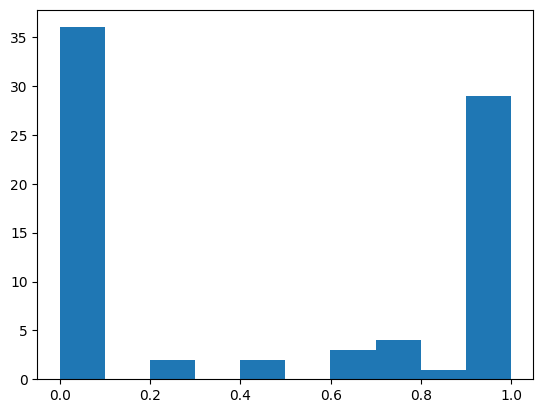

In [6]:
#Function that lets me display things with a custom # of rows
def Display_Max_Rows(info, rows = None):
  pd.set_option('display.max_rows', rows)
  print(info) #I wondered for a moment if decorators would let me do this with functions instead of just data (e.g. Display_Max_Rows(print(missing))) but I have to shelve that for now.
  pd.set_option('display.max_rows', 10)

#Display every column's missing %
Display_Max_Rows(missing)

#a histogram just for fun
plt.hist(missing)

From the above results, columns like `DATEACTION`, `DATECONVICTION`, and `TERMYR` are usable while columns like `DATE1`, `FILED`, `CLEMENCYFORM`, `AGE`,`TOTALWAIT`, and `GENDER` are unsable with around 99%+ data missing from these columns.
  - some might only exist for modern years-to find out

In [12]:
#(GS-code orginator)
df_model[['PRES', 'TERMYR', 'CLEMENCY']].value_counts().head(20)

Display_Max_Rows(df_model.groupby('PRES')['CASEID'].count().sort_values(ascending=False))

PRES
Wils(2)       1600
Hoov          1223
LBJ            853
Nix            730
Kenn           572
Cart           567
TRoos (1)      514
Linc           334
Polk           268
JQAd           183
VanB           168
Buch           149
Pierce         140
Monr           124
Madis          113
Bush           108
Jeff            41
Taylor          38
Obama           23
Adams           21
 Jeff            3
Harr             3
COPY             1
Name: CASEID, dtype: int64


            CASEID  FILEID  PRES  PRESIDENT  TERMYR   PG  PG_A  PAGE  SSVOL  \
YEARACTION                                                                    
1798             3       3     3          3       3    3     0     0      3   
1799             5       5     5          5       5    5     0     0      5   
1800             9       9     9          9       9    9     0     0      9   
1801            13      13    13         13      13   13     0     0     13   
1802             8       8     8          8       8    8     0     0      8   
1803            10      10    10         10      10   10     0     0     10   
1804            16      16    16         16      16   16     0     0     16   
1805             1       1     1          1       1    1     0     0      1   
1809            23      23    23         23      23   22     0     0     23   
1810            26      26    26         26      26   25     0     0     26   
1811            19      19    19         19      19 

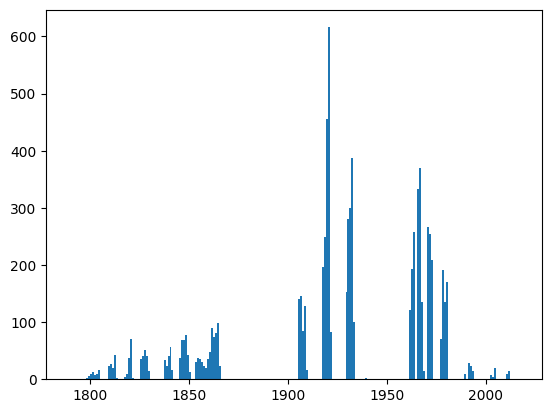

In [38]:
#another angle, charting each row by its year
#about 3% of DATEACTION is missing so please keep this in mind
df_model['YEARACTION'] = df_model['DATEACTION'].dt.year
plt.hist(df_model['YEARACTION'], bins = range(1789,2018))

Display_Max_Rows(df_model.groupby('YEARACTION').count())

Here we can see massive temporal gaps in our dataset, particularly from the 1850s-1900s and the 1930s/1940s. This is likely due to missingness present in the four key columns used to drop missingness (key_cols = ['PRES', 'TERMYR', 'CLEMENCY', 'DATEACTION']). Below is a histogram of DATEACTION (grouped by year) in the original dataset, which should show that it is not responsible for the gaps:

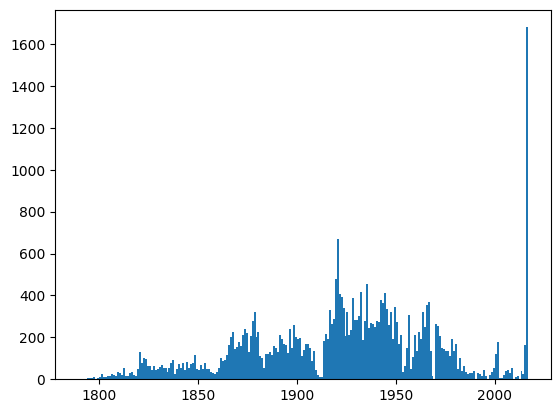

In [46]:
_ = plt.hist(df_clean['DATEACTION'].dt.year, bins = range(1789,2018))

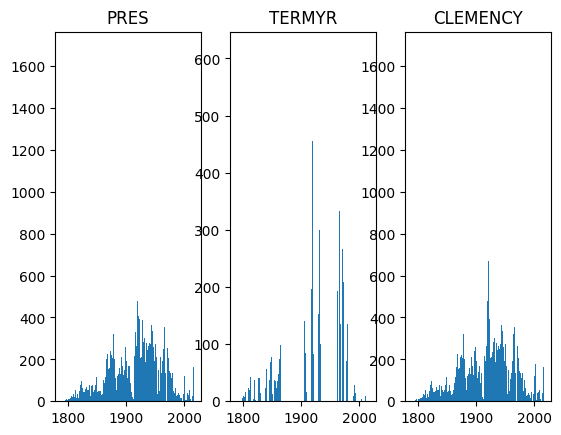

In [71]:
#Where is the missingness?

key_cols_test = key_cols.copy()
key_cols_test.remove('DATEACTION')

fig, ax = plt.subplots(nrows = 1,ncols = len(key_cols_test))
df_clean_test = {}
for k in range(len(key_cols_test)):
  df_clean_test[k] = df_clean.dropna(subset=key_cols_test[k]).reset_index(drop=True)
  ax[k].hist(df_clean_test[k]['DATEACTION'].dt.year, bins = range(1789,2018))
  ax[k].set_title(key_cols_test[k])


And thus, TERMYR was removed.

## Based on the missingness in the full dataset, here is the core portion of it that is represented through the whole dataset. Here columns are only missing 0-5% of their data.
- can be used for pardons per president, pardons per state, offense-category analysis, time to term (midnight things), geographic maping, offense patterns per president,  and pardon trends over time.

In [9]:
#(GS-code orginator)
core_cols = [
    'CASEID', 'FILEID', 'PRES', 'CLEMENCY', 'CLEMENCY_A',
    'DATEACTION', 'RECIPIENT', 'OFFENSE',
    'STATECONVICTION', 'STATE'
]

df_core = df_clean[core_cols].dropna(subset=['DATEACTION'])
print(df_core.shape)
df_core.head()

(31081, 10)


,CASEID,FILEID,PRES,CLEMENCY,CLEMENCY_A,DATEACTION,RECIPIENT,OFFENSE,STATECONVICTION,STATE
0,1,"(01) George Washington, 1st Term",Wash,P,,1791-02-01,Freeman,counterfeiting,,NJ
1,2,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,H. Usher,smuggling,,RI
2,3,"(02) George Washington, 2nd Term",Wash,P-R,,1793-06-01,G. Usher,smuggling,,RI
3,4,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-15,David Blair,illegal importation,,GA
4,5,"(02) George Washington, 2nd Term",Wash,P-R,,1794-04-25,Joseph Ravara,threatening letter (misd),,PA


## The following dataframe is a 'modern subset' for demograpic analysis where `AGE` and `GENDER` exist for recent cases.

- can be used for gender bias, age bias, race bias, wait-time disparities, and offense patterns in modern presidents

In [10]:
#(GS-code orginator)
df_demo = df_clean[df_clean['AGE'].notna() & df_clean['GENDER'].notna()]
print(df_demo.shape)
df_demo.head()

(133, 77)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,CRIMECAT,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE
30096,30097,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,3.753425,4.183562,0.0,,,29-JUN-2010
30097,30098,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,73.0,1.509589,2.575342,0.0,,,09-NOV-2009
30098,30099,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,85.0,3.684932,4.553425,0.0,,,20-JAN-2010
30099,30100,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,66.0,1.764384,2.632877,0.0,,,20-JAN-2010
30100,30101,"(63) Barack Obama, 1st Term)",Obama,,2.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,58.0,3.871233,4.378082,0.0,,,01-JUN-2010


## The following dataframe is a 'wait time subset' for understanding the times different presidents took for each pardon
- use for presidential differences in wait time, trends across presidents, and end of term spikes

In [11]:
#(GS-code orginator)
df_clean['WAIT_DAYS'] = (
    df_clean['DATEACTION'] - df_clean['DATECONVICTION']
).dt.days

df_wait = df_clean[df_clean['WAIT_DAYS'].notna()]
print(df_wait.shape)
df_wait.head()


(25173, 78)


,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,SSID,...,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE,WAIT_DAYS
32,33,"(03) John Adams, 1st Term",Adams,,2.0,21.0,NaN,NaN,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,154.0
41,42,"(03) John Adams, 1st Term",Adams,,4.0,30.0,NaN,NaN,1.0,24.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,49.0
43,44,"(03) John Adams, 1st Term",Adams,,4.0,32.0,NaN,NaN,1.0,26.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,929.0
49,50,"(03) John Adams, 1st Term",Adams,,4.0,36.0,NaN,NaN,1.0,30.0,...,NaN,NaN,NaN,NaN,NaN,0.0,,,,181.0
61,62,"(03) John Adams, 1st Term",Adams,,4.0,40.0,NaN,NaN,1.0,34.0,...,NaN,NaN,NaN,NaN,NaN,1.0,,,,88.0
